# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import CountryCapital
from susceptibility_scores import construct_paths_and_dataset_kwargs

### Preamble

In [12]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "CountryCapital"
QUERY_ID = None
# RAW_DATA_PATH = "data/CountryCapital/real-fake-historical-country-capital.csv"
# SEED = 1

RAW_DATA_PATH = "data/CountryCapital/yago-real-gpt-fake-country-capital.csv"
SEED = 2

MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 450
MAX_ENTITIES = 90
CAP_PER_TYPE = True
ABLATE_OUT_RELEVANT_CONTEXTS = False
UNIFORM_CONTEXTS = False
DEDUPLICATE_ENTITIES = False
ENTITY_SELECTION_FUNC_NAME = "random_sample"
# ENTITY_SELECTION_FUNC_NAME = "top_entity_uri_degree"
# ENTITY_SELECTION_FUNC_NAME = "top_entity_namesake_degree"
ANSWER_MAP = None
OVERWRITE = True
ENTITY_TYPES = ["entities", "gpt_fake_entities"]
# ENTITY_TYPES = ["entities", "fake_entities"]
QUERY_TYPES = ["closed", "open"]
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["capitals", "analysis"]
LOG_DATASETS = True

In [13]:
# Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    answers_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID=QUERY_ID,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    OVERWRITE=OVERWRITE,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

Data dir: data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2
Model dir: data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2/models/EleutherAI/pythia-6.9b-deduped-8bit


In [14]:
# Analysis dir
analysis_dir = os.path.join(data_dir, "analysis")
print(f"Analysis dir: {analysis_dir}")

Analysis dir: data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2/analysis


In [15]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

Overwriting datasets (if they already exist) at data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2/inputs/entities.json, None, data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2/inputs/contexts.json, and data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2/inputs/queries.json.


In [16]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [17]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


{'DATASET_NAME': 'CountryCapital', 'QUERY_ID': None, 'RAW_DATA_PATH': 'data/CountryCapital/yago-real-gpt-fake-country-capital.csv', 'SEED': 2, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 450, 'MAX_ENTITIES': 90, 'CAP_PER_TYPE': True, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': False, 'DEDUPLICATE_ENTITIES': False, 'ENTITY_SELECTION_FUNC_NAME': 'random_sample', 'ANSWER_MAP': None, 'OVERWRITE': True, 'ENTITY_TYPES': ['entities', 'gpt_fake_entities'], 'QUERY_TYPES': ['closed', 'open'], 'BATCH_SZ': 16, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['capitals', 'analysis'], 'DATASET_KWARGS_IDENTIFIABLE': {'max_contexts': 450, 'max_entities': 90, 'cap_per_type': True, 'raw_data_path': 'data/CountryCapital/yago-real-gpt-fake-country-capital.csv', 'ablate_out_relevant_contexts': False, 'uniform_contexts': False, 'deduplicate_entities': False, 'entity_selection_func_name': 'random_sample', 'overwrite': True, 'entities_path'

### Load Data

In [19]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path,
    index_col=0,
    converters={"contexts": literal_eval, "entity": literal_eval},
)

In [20]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/CountryCapital/CountryCapital-mc450-me90-cappertype-ES_random_sample/2/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2b6b40b2c880>.


### Analyze Data

In [21]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,answer,contexts,susceptibility_score,full_query_example
0,capital_of,Q: What is the capital of {}?\nA:,"(Pardubice District,)",Pardubice,[The capital of Russian Republic is Boorowa.\n...,0.208689,The capital of Russian Republic is Boorowa.\nQ...
1,capital_of,Q: What is the capital of {}?\nA:,"(Outaouais,)",Gatineau,[The capital of Russian Republic is Boorowa.\n...,0.130991,The capital of Russian Republic is Boorowa.\nQ...
2,capital_of,Q: What is the capital of {}?\nA:,"(Berkshire County,)",Pittsfield,[The capital of Russian Republic is Boorowa.\n...,0.201889,The capital of Russian Republic is Boorowa.\nQ...
3,capital_of,Q: What is the capital of {}?\nA:,"(Cojedes,)",San Carlos,[The capital of Russian Republic is Boorowa.\n...,0.206270,The capital of Russian Republic is Boorowa.\nQ...
4,capital_of,Q: What is the capital of {}?\nA:,"(Artvin Province,)",Artvin,[The capital of Russian Republic is Boorowa.\n...,0.233515,The capital of Russian Republic is Boorowa.\nQ...


In [22]:
val_df_contexts_per_qe["entity"].value_counts()

(Pardubice District,)               2
(Abundance Organic Grocers,)        2
(Nexus Network,)                    2
(Arcanum,)                          2
(Foundation Fusion,)                2
                                   ..
(San Pedro de Macorís,)             2
(Russian Republic,)                 2
(Laurentides,)                      2
(Socialist Republic of Romania,)    2
(Polar Peak Productions,)           2
Name: entity, Length: 90, dtype: int64

In [23]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['The capital of Russian Republic is Boorowa.\n',
 'The capital of Basht County is Bartoszyce.\n',
 'The capital of Vilcas Huamán is Dakar.\n',
 "The capital of Heron's Rest is Baturaja.\n",
 'The capital of Mbale District is Kayu Agung.\n',
 'The capital of Monolith Management is Struga.\n',
 'The capital of Boulkiemdé Province is Skopje.\n',
 'The capital of Outaouais is Tiszakécske.\n',
 'The capital of Infinite Loop Tech Repair is Winner.\n',
 'The capital of Saguenay–Lac-Saint-Jean is Ljubljana.\n']

In [24]:
import re

p = r"of\s(.*?)(?=\sis\b)"
c_ents = [
    re.search(p, text).group(1) for text in val_df_contexts_per_qe.iloc[0]["contexts"]
]
ents = val_df_contexts_per_qe["entity"].tolist()
if (
    DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
    and len(set(c_ents).intersection(set(ents))) != 0
):
    raise ValueError(
        "ablate_out_relevant_contexts is True, but the contexts contain entities in the entities list."
    )

In [26]:
country_data

,capital,type
country,,
Syzransky District,Syzran,countryCapital
Temnikovsky Uyezd,Temnikov,countryCapital
Cameron County,Brownsville,countryCapital
Kayin State,Hpa-An,countryCapital
arrondissement of Nice,Nice,countryCapital
...,...,...
Polar Climate Initiative,Pago Pago,gptFakeCountryCapital
Nexus Valley,Rottweil,gptFakeCountryCapital
Wanderlust Travel Magazine,Ciechanów,gptFakeCountryCapital


In [34]:
country_data = pd.read_csv(
    DATASET_KWARGS_IDENTIFIABLE["raw_data_path"],
    # os.path.join("data", DATASET_NAME, "real-fake-country-capital.csv"),
    index_col=0,
)
country_data["country"] = country_data["country"].apply(lambda x: (x,))

In [35]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    country_data[["country", "type", "is_real"]],
    left_on="entity",
    right_on="country",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "type",
        "is_real",
        "susceptibility_score",
    ]
]

In [36]:
val_df_per_qe[val_df_per_qe["query_form"] == "The capital of {} is"].sort_values(
    by="susceptibility_score"
)

,q_id,query_form,entity,type,is_real,susceptibility_score
126,capital_of,The capital of {} is,"(Dominican Republic,)",countryCapital,True,0.060061
115,capital_of,The capital of {} is,"(Socialist Republic of Romania,)",countryCapital,True,0.111741
119,capital_of,The capital of {} is,"(Kingdom of Yugoslavia,)",countryCapital,True,0.117910
96,capital_of,The capital of {} is,"(Tomaszów Mazowiecki County,)",countryCapital,True,0.174211
101,capital_of,The capital of {} is,"(Bolivian State,)",countryCapital,True,0.184710
...,...,...,...,...,...,...
144,capital_of,The capital of {} is,"(Infinite Loop Tech Repair,)",gptFakeCountryCapital,False,1.229702
159,capital_of,The capital of {} is,"(Jewel of the Sea Aquarium,)",gptFakeCountryCapital,False,1.325326
171,capital_of,The capital of {} is,"(Hydrangea Water Treatment,)",gptFakeCountryCapital,False,1.522597
142,capital_of,The capital of {} is,"(Elevation Rock Climbing Gym,)",gptFakeCountryCapital,False,1.660724


In [37]:
val_df_per_qe[val_df_per_qe["query_form"] == "Q: What is the capital of {}?\nA:"][
    ["entity", "is_real", "susceptibility_score"]
].sort_values(
    by="susceptibility_score"
)  # [val_df_per_qe["entity"] == "Albania"]

,entity,is_real,susceptibility_score
36,"(Dominican Republic,)",True,0.057850
29,"(Kingdom of Yugoslavia,)",True,0.073470
25,"(Socialist Republic of Romania,)",True,0.085187
28,"(San Pedro de Macorís,)",True,0.100520
44,"(Mbale District,)",True,0.100649
...,...,...,...
18,"(Lubāna Municipality,)",True,0.622831
9,"(Mat Municipality,)",True,0.645609
20,"(Dzun-Khemchiksky District,)",True,0.658852
33,"(Maloyaroslavetsky District,)",True,0.661093


In [38]:
# anchor on countries that have changed names? e.g. Jerusalem/Israel, Leningrad/Russia? pick things that are narrowly true
# fictional countries/capitals
# find ordinal groups of countries and capitals, where we have an intuition on which ones should be more/less sensitive and then see whether the results fit that
# https://en.wikipedia.org/wiki/List_of_city_name_changes
# https://en.wikipedia.org/wiki/List_of_former_national_capitals
# many factors (e.g. geography? etc?) - we can look for effects

# Side question: does a LM anchor on word choices and take it into account going forward?

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

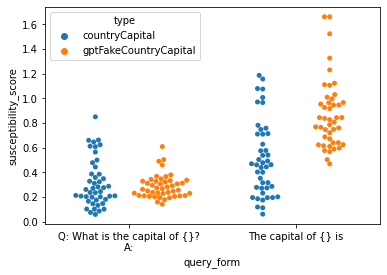

In [42]:
sns.swarmplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="is_real",
    dodge=True,
    # jitter=0.1,
    # legend="full",
)

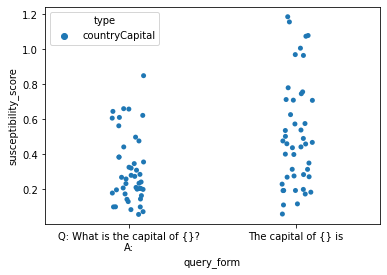

In [40]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["type"].isin(
            [
                "countryCapital",
                # "famousFictionalCountryCapital",
                "historicalCountryCapital",
                "dreamfictionalCountryCapital",
                # "fakeCountryCapital",
            ]
        )
    ],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
fig

### Examining model outputs

In [24]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [25]:
def print_top_k_next_token_probs(model, tokenizer, query, entity, context, k=50):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=context),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [25]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_contexts_per_qe[
    val_df_contexts_per_qe["query_form"] == query_forms[1]
].sort_values(by="susceptibility_score")

,q_id,query_form,entity,contexts,susceptibility_score
94,capital_of,The capital of {} is,"(Nagorno-Karabakh Republic,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.015117
103,capital_of,The capital of {} is,"(Republic of China (Taiwan),)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.027095
91,capital_of,The capital of {} is,"(Paraguay,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.035673
107,capital_of,The capital of {} is,"(Kyrgyzstan,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.048575
101,capital_of,The capital of {} is,"(Somalia,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.062413
...,...,...,...,...,...
141,capital_of,The capital of {} is,"(Consuleo,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.751852
136,capital_of,The capital of {} is,"(Wula,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.760516
148,capital_of,The capital of {} is,"(Fictional Country,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.796028
120,capital_of,The capital of {} is,"(Cadasa,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.831525


In [64]:
pp = pprint.PrettyPrinter()
row = (
    val_df_contexts_per_qe[val_df_contexts_per_qe["query_form"] == query_forms[1]]
    .sort_values(by="susceptibility_score")
    .iloc[0]
)
entity = row["entity"]
contexts = row["contexts"][430:440]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context=""))
print("CMI:", estimate_cmi(query, entity, contexts, model, tokenizer))

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(model, tokenizer, query, entity, context="", k=50)
print("\n\n")
for context in contexts[:5]:
    print(f"*{format_query(query=query, entity=entity, context=context)}*")
    print_top_k_next_token_probs(model, tokenizer, query, entity, context, k=50)
    print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context=""),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

***Investigating the following query for entity ('Nagorno-Karabakh Republic',):***
The capital of Nagorno-Karabakh Republic is
CMI: 0.017251218948326867
***Top-k next token probs WITHOUT any context:***


/scratch/tmp.41099897.kevidu/ipykernel_27225/2345229264.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[(0.898, 'ĠSte', 2951), (0.0291, 'ĠY', 714), (0.01984, 'Ġthe', 253), (0.01865, 'ĠB', 378), (0.005775, 'ĠT', 308), (0.00436, 'Ġa', 247), (0.002972, 'Ġoccupied', 13598), (0.002262, 'Ġalso', 671), (0.001789, 'Ċ', 187), (0.001747, 'ĠSh', 1608), (0.000935, 'Ġits', 697), (0.000832, 'Ġcapital', 5347), (0.000769, 'Ġcurrently', 4390), (0.0007343, 'Ġnot', 417), (0.000717, 'ĠM', 353), (0.000706, 'ĠN', 427), (0.000576, 'ĠArts', 15118), (0.0005083, 'Ġin', 275), (0.0004778, 'ĠNK', 18156), (0.0004704, 'ĠGy', 20925), (0.000463, 'Ġconsidered', 2783), (0.0004385, 'Ġan', 271), (0.0004249, 'Ġcity', 2846), (0.0004249, 'Ġlocated', 4441), (0.0004022, 'Ġnamed', 4907), (0.000396, 'ĠS', 322), (0.000396, 'Ġrepublic', 23822), (0.0003662, 'Ġwithin', 1561), (0.0003579, ',', 13), (0.0003467, 'Ġ"', 346), (0.0003335, 'ĠE', 444), (0.0003037, 'ĠA', 329), (0.0002897, ':', 27), (0.0002897, 'Ġcalled', 1925), (0.0002875, 'ĠAl', 1219), (0.0002556, 'ĠEl', 3599), (0.0002365, 'ĠArt', 3975), (0.000231, 'ĠAst', 15123), (0.0002292

### Correlation with Pile frequency

In [26]:
unigram_frequencies = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-unigrams.bin",
    dtype=np.int64,
    mode="r",
    shape=(50277,),
)
view = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia_pile_idxmaps/pile_0.87_deduped_text_document.bin",
    dtype=np.uint16,
    mode="r",
)

In [34]:
import zstandard as zstd
import pickle
from scipy.sparse import load_npz

file_path = (
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-deduped-bigrams.zst"
)
# # Open the zstd file for reading in binary mode
# with open(file_path, 'rb') as compressed_file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(compressed_file) as reader:
#         # Decompress the zstd file and load the pickled data
#         pickled_data = pickle.loads(reader.read())

# Reconstruct the SciPy sparse array
# sparse_array = load_npz(pickled_data)

with open(file_path, "rb") as f:
    data = f.read()

dctx = zstd.ZstdDecompressor()
decompressed = dctx.decompress(data)
pickled_scipy = pickle.loads(decompressed)

AttributeError: Can't get attribute 'csr_array' on <module 'scipy.sparse._csr' from '/cluster/home/kevidu/.local/lib/python3.10/site-packages/scipy/sparse/_csr.py'>

In [ ]:
len(decompressed), type(decompressed), decompressed[:5]

In [25]:
entities = val_df_contexts_per_qe["entity"].apply(lambda x: x[0]).unique().tolist()

In [26]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)
tokenized_entities = [tuple(e) for e in tokenizer(entities)["input_ids"]]
tokenized_entities_prespace = [
    tuple(e) for e in tokenizer([" " + e for e in entities])["input_ids"]
]
tokenized_entities
tokenized_entities_prespace
entities_to_freqs = {
    e: {tokenized_entities[i]: 0, tokenized_entities_prespace[i]: 0}
    for i, e in enumerate(entities)
}
entities_to_freqs["Zimbabwe"]

# tokenized_entities
# {
#     entity:
#         {
#             tokens_without_space: count,
#             tokens_with_space: count
#         }
# }

{(59, 35976): 0, (38581,): 0}

In [43]:
# relevant_token_seqs = set(tokenized_entities + tokenized_entities_prespace)
relevant_token_seqs = set(tokenized_entities_prespace)
relevant_token_seqs

{(330, 15333, 66),
 (353, 636, 263),
 (367, 12043, 11491),
 (380, 47708, 6056),
 (399, 29420, 273, 41813),
 (401, 15835, 17241),
 (411, 3627),
 (416, 321, 10157, 571),
 (416, 1595, 266, 255, 723, 66),
 (416, 11318),
 (418, 408, 532, 307),
 (427, 351, 6736),
 (427, 1596, 571),
 (443, 5945),
 (444, 1274, 66),
 (473, 33205, 5741),
 (500, 1441, 316),
 (611, 6147, 4233, 91, 18549),
 (611, 16208, 552, 1758),
 (659, 1377, 91, 518),
 (1023, 445, 262, 8125),
 (1457, 2263, 264, 9409),
 (1457, 40868, 90),
 (1780, 21720, 261),
 (1986, 11491, 11442, 11011),
 (2263, 261, 5503),
 (2903, 90, 5182),
 (2956, 19438, 333),
 (3083, 11825),
 (3189, 2131),
 (3512, 19257),
 (3532, 251, 4412),
 (3660, 38148),
 (4031, 4448, 301, 34526),
 (4135,),
 (4563, 1657, 80),
 (4687, 273, 329, 719),
 (4687, 273, 4135, 313, 53, 2284, 10320, 10),
 (4687, 273, 7511, 18442),
 (4782, 8170, 7531, 8694, 1870, 366),
 (4952, 8125),
 (5003, 50190),
 (5769, 25183),
 (6176,),
 (6984, 2320),
 (7949, 5410, 66),
 (8229, 15354),
 (8502,)

In [44]:
from collections import Counter

unigram_tokens = {
    t: unigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 1
}
unigram_tokens

{(44637,): 250587,
 (25270,): 548240,
 (46699,): 224094,
 (16842,): 1059489,
 (31683,): 431605,
 (17358,): 1093472,
 (45914,): 226142,
 (4135,): 8029900,
 (20341,): 729429,
 (38581,): 301247,
 (6176,): 4613886,
 (8502,): 1698202}

In [ ]:
bigram_tokens = {
    t: bigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 2
}

In [45]:
for e, freq_dicts in entities_to_freqs.items():
    total = 0
    for token_seqs in freq_dicts.keys():
        if len(token_seqs) == 1:
            freq_dicts[token_seqs] = unigram_frequencies[token_seqs[0]]
        if len(token_seqs) == 2:
            freq_dicts[token_seqs] = bigram_frequencies[token_seqs]
        total += freq_dicts[token_seqs]
    freq_dicts["total"] = total

38581 301247
25270 548240
22800 749642
4135 8029900
45914 226142
16842 1059489
46699 224094
37796 329569
6176 4613886
20341 729429
44637 250587
24900 626526
8502 1698202
45901 135822
31683 431605
39312 289723
17358 1093472


In [46]:
entities_to_freqs

{'Zimbabwe': {(59, 35976): 0, (38581,): 301247, 'total': 903741},
 'Paraguay': {(4221, 19438, 333): 0, (2956, 19438, 333): 0, 'total': 0},
 'Finland': {(17398, 1373): 0, (25270,): 548240, 'total': 1644720},
 'New Caledonia': {(4257, 2263, 264, 9409): 0,
  (1457, 2263, 264, 9409): 0,
  'total': 0},
 'Nagorno-Karabakh Republic': {(47,
   356,
   41530,
   14,
   40016,
   357,
   18980,
   4687): 0,
  (21987, 41530, 14, 40016, 357, 18980, 4687): 0,
  'total': 0},
 'Faroe Islands': {(24234, 3703, 18708): 0,
  (10351, 3703, 18708): 0,
  'total': 0},
 'China': {(22800,): 749642, (4135,): 8029900, 'total': 26338626},
 'United Kingdom Northern Ireland': {(11586, 11491, 11442, 11011): 0,
  (1986, 11491, 11442, 11011): 0,
  'total': 0},
 'Tanzania': {(53, 11670, 16642): 0, (45914,): 226142, 'total': 678426},
 'Sweden': {(42589, 257): 0, (16842,): 1059489, 'total': 3178467},
 'Honduras': {(41, 857, 27356): 0, (44509, 27356): 0, 'total': 0},
 'Somalia': {(52, 7838, 571): 0, (46699,): 224094, 'tot

In [68]:
entity_counts = dict(
    sorted(
        {
            (k,): v["total"] for k, v in entities_to_freqs.items() if v["total"] != 0
        }.items(),
        key=lambda x: x[1],
    )
)
ent_freq_df = pd.DataFrame(
    list(entity_counts.items()), columns=["entity", "ent_frequency"]
)
ent_freq_df

In [81]:
val_df_per_qe_with_freq = val_df_per_qe.merge(ent_freq_df)
val_df_per_qe_with_freq["log_ent_frequency"] = val_df_per_qe_with_freq[
    "ent_frequency"
].apply(np.log)
val_df_per_qe_with_freq

,q_id,query_form,entity,type,is_real,susceptibility_score,ent_frequency,log_ent_frequency
0,capital_of,Q: What is the capital of {}?\nA:,"(Zimbabwe,)",countryCapital,True,0.055717,903741,13.714298
1,capital_of,The capital of {} is,"(Zimbabwe,)",countryCapital,True,0.083346,903741,13.714298
2,capital_of,Q: What is the capital of {}?\nA:,"(Finland,)",countryCapital,True,0.038184,1644720,14.313081
3,capital_of,The capital of {} is,"(Finland,)",countryCapital,True,0.070862,1644720,14.313081
4,capital_of,Q: What is the capital of {}?\nA:,"(China,)",countryCapital,True,0.074832,26338626,17.086547
5,capital_of,The capital of {} is,"(China,)",countryCapital,True,0.248528,26338626,17.086547
6,capital_of,Q: What is the capital of {}?\nA:,"(Tanzania,)",countryCapital,True,0.072143,678426,13.427531
7,capital_of,The capital of {} is,"(Tanzania,)",countryCapital,True,0.086598,678426,13.427531
8,capital_of,Q: What is the capital of {}?\nA:,"(Sweden,)",countryCapital,True,0.039669,3178467,14.971910
9,capital_of,The capital of {} is,"(Sweden,)",countryCapital,True,0.066374,3178467,14.971910


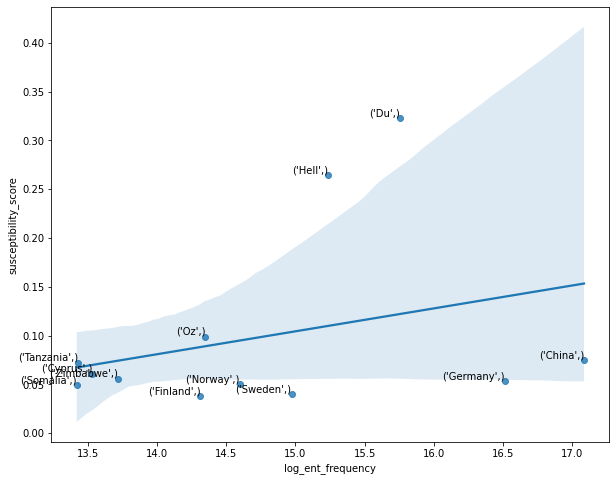

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
df = val_df_per_qe_with_freq[val_df_per_qe_with_freq["query_form"] == query_forms[0]]
plot = sns.regplot(
    data=df,
    x="log_ent_frequency",
    y="susceptibility_score",
    # logx=True,
    # hue="query_form",
    ax=ax,
    label=True,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

for i, row in df.iterrows():
    ax.text(
        row["log_ent_frequency"],
        row["susceptibility_score"],
        row["entity"],
        ha="right",
        va="bottom",
    )

plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic_ent_frequency"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# 24000 min = 2+ weeks of CPU hours to finish lmao
from tqdm.auto import trange
CHUNK_SIZE = 50_000_000
VOCAB_SIZE = 50_277
window_size = 1
for i in trange(0, len(view), CHUNK_SIZE):
    chunk = view[i : i + CHUNK_SIZE]
    for j in trange(len(chunk) - (window_size - 1)):
        ngram = tuple(chunk[j: j+window_size])
        if ngram in unigram_tokens:
            unigram_tokens[ngram] += 1        
    # counts += np.bincount(chunk, minlength=len(counts))

  0%|          | 0/4144 [00:00<?, ?it/s]

  0%|          | 0/50000000 [00:00<?, ?it/s]

  0%|          | 0/50000000 [00:00<?, ?it/s]

  0%|          | 0/50000000 [00:00<?, ?it/s]

In [ ]:
unigram_frequencies

In [31]:
tokenizer.convert_ids_to_tokens([38581])

['ĠZimbabwe']

In [ ]:
wandb.finish()